In [34]:
import pandas as pd
import numpy as np
import joblib as jb
import math

pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
def root_mean_squared_error(y_test, preds):
    return math.sqrt(mean_squared_error(y_true=y_test, y_pred=preds))    

### Generate labels

In [3]:
month_to_predict_1 = 33
month_to_predict_2 = 32
month_to_predict_3 = 31
month_to_predict_4 = 30

In [4]:
items = pd.read_csv("data/items.csv")
items_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
shops = pd.read_csv("data/shops.csv")

In [5]:
df = pd.merge(items, items_categories, on="item_category_id", how="inner")
df = pd.merge(df, sales_train, on="item_id", how="inner")
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [6]:
def label_df(df, month_to_label):
    to_label = df[df["date_block_num"] == month_to_label]
    
    print("Before deleting negative item_cnt_day:", len(to_label))
    to_label = to_label[to_label["item_cnt_day"] > 0]
    print("After deleting negative item_cnt_day", len(to_label))
    
    labeled = to_label.groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum", "item_category_id":"max"}).reset_index().rename(columns={"item_cnt_day":"label"})
    
    print("Before taking 99th percentil of label:", len(labeled))
    labeled = labeled[labeled.label <= np.percentile(a=labeled["label"], q=99)]
    print("After taking 99th percentil of label:", len(labeled))    
    return labeled

In [7]:
labeled_1 = label_df(df, month_to_predict_1)

Before deleting negative item_cnt_day: 53514
After deleting negative item_cnt_day 53386
Before taking 99th percentil of label: 31521
After taking 99th percentil of label: 31218


In [8]:
labeled_2 = label_df(df, month_to_predict_2)

Before deleting negative item_cnt_day: 50588
After deleting negative item_cnt_day 50443
Before taking 99th percentil of label: 29652
After taking 99th percentil of label: 29382


In [9]:
labeled_3 = label_df(df, month_to_predict_3)

Before deleting negative item_cnt_day: 57029
After deleting negative item_cnt_day 56913
Before taking 99th percentil of label: 33472
After taking 99th percentil of label: 33180


In [10]:
labeled_4 = label_df(df, month_to_predict_4)

Before deleting negative item_cnt_day: 55549
After deleting negative item_cnt_day 55420
Before taking 99th percentil of label: 33515
After taking 99th percentil of label: 33181


In [11]:
print(len(labeled_1))
labeled_1.head()

31218


,shop_id,item_id,label,item_category_id
0,2,31,1.0,37
1,2,486,3.0,73
2,2,787,1.0,49
3,2,794,1.0,73
4,2,968,1.0,40


#### Generate dataframe with features

In [12]:
#Dictionary whose keys are features files and associated values are joining columns
features_folders = ["generated/features_train_1/", "generated/features_train_2/", "generated/features_train_3/", "generated/features_train_4/"]

#Debe coincider el mes para que se calculo el label con el mes para el cual se generaron los features.
dfs_init = [labeled_1, labeled_2, labeled_3, labeled_4]

features_dict = {
    "features_shop_and_categories.csv":["shop_id", "item_category_id"],
    "features_categories.csv":"item_category_id",
    "features_shops.csv":"shop_id",
    "features_items_and_shop.csv": ["item_id", "shop_id"],
    "features_items.csv":"item_id"    
}

In [13]:
dfs = []
for x in range(len(features_folders)):
    df = dfs_init[x]
    features_folder = features_folders[x]    
    for features_file in features_dict:
        df_features = pd.read_csv(features_folder + features_file)
        joining_cols = features_dict[features_file]
        df = pd.merge(df, df_features, on=joining_cols, how="left")
    dfs.append(df)    
print(len(dfs))

4


In [14]:
df = dfs[0]
for x in range(1, len(dfs)):
    df = df.append(dfs[x])
    
print("Len of train datarame:", len(df))
df.head()

Len of train datarame: 126961


,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,tot_cat_by_shops,items_sold_last_month,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,59.0,822.0,1.750,7.0,1.500000,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,4.0,699.0,581.503264,147.62,152.605715,551.38,53.0
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,59.0,822.0,1.625,13.0,0.744024,3.0,1.0,1.0,NaN,NaN,2.0,NaN,1.0,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,NaN,55.0,160.0,59.0,822.0,1.000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,59.0,822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3300.0,3282.352941,3000.00,72.760688,300.00,8.0
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,59.0,822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399.0,357.765780,55.00,90.061632,344.00,43.0


#### Analyze and fill na values of dataframe with features

In [15]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                    420
hist_sales_mean_cat_by_shop                   420
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                    420
hist_sales_max_cat_by_shop                    420
sold_cat_last_month_by_shop                  1916
total_shops_of_category                         2
total_items_of_category                         2
tot_cat_by_shops                              258
items_sold_last_month                         258
hist_sales_mean_item_by_shop                22250
hist_sales_sum_item_by_shop                 22250
hist_sales_std_item_by_shop                 37875
hist_sales_max_item_by_shop                 22250
hist_sales_min_item_by_shop                 22250
purchases_item_in_shop_last_month           74548


In [16]:
df["hist_sales_sum_cat_by_shop"] = df["hist_sales_sum_cat_by_shop"].fillna(0)
df["hist_sales_mean_cat_by_shop"] = df["hist_sales_mean_cat_by_shop"].fillna(0)
df["hist_sales_max_cat_by_shop"] = df["hist_sales_max_cat_by_shop"].fillna(0)
df["hist_sales_min_cat_by_shop"] = df["hist_sales_min_cat_by_shop"].fillna(0)
df["sold_cat_last_month_by_shop"] = df["sold_cat_last_month_by_shop"].fillna(0)
df["tot_cat_by_shops"] = df["tot_cat_by_shops"].fillna(df["tot_cat_by_shops"].mean())
df["items_sold_last_month"] = df["items_sold_last_month"].fillna(0)
df["hist_sales_mean_item_by_shop"] = df["hist_sales_mean_item_by_shop"].fillna(0)
df["hist_sales_sum_item_by_shop"] = df["hist_sales_sum_item_by_shop"].fillna(0)
df["hist_sales_max_item_by_shop"] = df["hist_sales_max_item_by_shop"].fillna(0)
df["hist_sales_min_item_by_shop"] = df["hist_sales_min_item_by_shop"].fillna(0)
df["purchases_item_in_shop_last_month"] = df["purchases_item_in_shop_last_month"].fillna(0)
for x in range(5):
    df["purchases_item_in_shop_month_" + str(x+2)].fillna(0, inplace=True)
df["total_months_with_sells_by_item_and_shop"] = df["total_months_with_sells_by_item_and_shop"].fillna(0)    
df.sample(10)

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,tot_cat_by_shops,items_sold_last_month,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell
19939,39,21404,1.0,40,1331.0,70.052632,25.533146,34.0,133.0,34.0,57.0,4917.0,56.0,907.0,1.166667,14.0,0.389249,2.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,32.0,15.0,12.0,399.0,258.099710,62.75,119.358480,336.25,50.0
4750,14,12725,1.0,40,4292.0,134.125000,69.971307,49.0,285.0,122.0,57.0,4874.0,60.0,1051.0,1.000000,1.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,31.0,31.0,1.0,399.0,354.380952,98.00,77.485155,301.00,21.0
21894,47,7723,1.0,19,7504.0,234.500000,68.535839,143.0,455.0,218.0,57.0,615.0,60.0,1895.0,1.857143,13.0,1.069045,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,31.0,22.0,7.0,2999.0,2929.402301,2098.50,225.122353,900.50,45.0
15162,31,18338,3.0,57,5508.0,172.125000,39.587184,97.0,260.0,97.0,50.0,418.0,62.0,5173.0,2.291667,55.0,1.334465,6.0,1.0,1.0,2.0,4.0,4.0,4.0,3.0,31.0,0.0,24.0,329.0,283.754037,161.00,49.519774,168.00,18.0
152,2,5037,1.0,19,4253.0,132.906250,56.521397,43.0,283.0,113.0,57.0,615.0,59.0,928.0,1.714286,12.0,1.112697,4.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,31.0,21.0,7.0,2599.0,2009.878279,749.00,614.797832,1850.00,50.0
13501,26,20377,1.0,72,323.0,9.787879,6.362771,2.0,25.0,25.0,58.0,621.0,61.0,1553.0,1.000000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,1.0,1899.0,1411.032557,717.00,276.333055,1182.00,49.0
32241,58,14417,1.0,40,24579.0,847.551724,279.634658,441.0,1642.0,522.0,57.0,4816.0,58.0,1678.0,1.000000,6.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,2.0,6.0,149.0,136.390860,28.00,32.201299,121.00,42.0
942,4,4413,2.0,55,4729.0,147.781250,42.565876,28.0,229.0,121.0,55.0,2271.0,61.0,901.0,1.500000,3.0,0.707107,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,31.0,30.0,2.0,299.0,296.494722,190.00,16.137978,109.00,37.0
29218,59,14262,1.0,38,518.0,16.187500,6.620776,5.0,31.0,13.0,57.0,303.0,60.0,1094.0,1.000000,3.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,11.0,3.0,999.0,300.192339,99.00,252.405018,900.00,46.0
25912,50,9469,1.0,72,1136.0,34.424242,15.951157,7.0,77.0,28.0,58.0,621.0,59.0,906.0,1.000000,1.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,32.0,32.0,1.0,2999.0,2443.303922,2272.00,183.340521,727.00,19.0


### Define target, prediction columns and train model

In [17]:
features = df

In [18]:
target_col = "label"
predictors = [x for x in features.columns if x != target_col]
predictors

['shop_id',
 'item_id',
 'item_category_id',
 'hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_item_in_shop_month_4',
 'purchases_item_in_shop_month_5',
 'purchases_item_in_shop_month_6',
 'month_last_purchase_of_item_in_shop',
 'month_first_purchase_of_item_in_shop',
 'total_months_with_sells_by_item_and_shop',
 'item_price_max',
 'item_price_mean',
 'item_price_min',
 'item_price_std',
 'diff_price_max_min',
 'total_shops_item_is_sell']

# RUN UNTIL HERE TO PROCESS LABELED DATAFRAME. THEN, TO TRAIN XGBOOST AGAIN, GO TO "TRY ESTIMATORS AND DECREASE LEARNING RATE"

# XGBOOST

### Split, train and save model

In [187]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

regressor = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=12,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

regressor.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbosity=1)

In [188]:
preds = regressor.predict(X_test)

In [189]:
print("RMSE:", root_mean_squared_error(y_test, preds))

RMSE: 1.340983282998613


In [190]:
jb.dump(regressor, "models/8 - depper.pkl")

['models/8 - depper.pkl']

## Tuning algorithm grid searching

In [49]:
def fit_model(xgb_estimator, dataframe_train, predictors_cols, target_col, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgb_estimator.get_xgb_params()
        xgb_train_matrix = xgb.DMatrix(dataframe_train[predictors_cols].values, label=dataframe_train[target_col].values)
        cvresult = xgb.cv(params, xgb_train_matrix, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        xgb_estimator.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    xgb_estimator.fit(dataframe_train[predictors_cols], dataframe_train[target_col], eval_metric='rmse')
        
    #Predict training set:
    train_prediction = xgb_estimator.predict(dataframe_train[predictors])
        
    #Print model report:
    print("\nModel Report") 
    print("RMSE :", root_mean_squared_error(dataframe_train[target_col].values, train_prediction))
                    
    feat_imp = pd.Series(xgb_estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Get n_estimators

Predictors are: ['shop_id', 'item_id', 'item_category_id', 'hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'tot_cat_by_shops', 'items_sold_last_month', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'purchases_item_in_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'purchases_item_in_shop_month_4', 'purchases_item_in_shop_month_5', 'purchases_item_in_shop_month_6', 'month_last_purchase_of_item_in_shop', 'month_first_purchase_of_item_in_shop', 'total_months_with_sells_by_item_and_shop', 'item_price_max', 'item_price_mean', 'item_price_min', 'item_price_std', 'diff_price_max_min', 'total_shops_item_is_sell']


/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
Accuracy : 0.8126660586945832


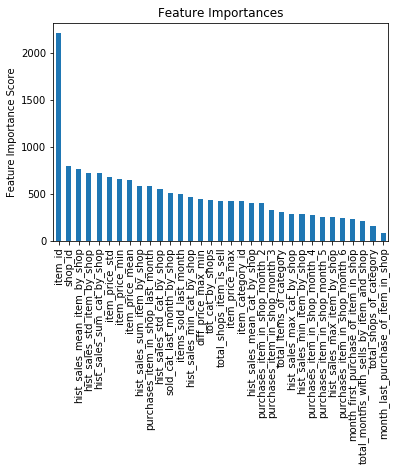

In [120]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost_n_estimators = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost_n_estimators, features, predictors, target_col)

In [122]:
optimal_n_estimators = xgboost_n_estimators.n_estimators
optimal_n_estimators

577

### Tune max_depth and min_child_weight

In [132]:
params_1 = {
 'max_depth':range(6,16,2),
 'min_child_weight':range(1,6,2)
}

In [133]:
grid_search_1 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_1, scoring='neg_mean_squared_error', n_jobs=4)

In [134]:
grid_search_1.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=577, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': range(6, 16, 2),
                         'min_child_weight': range(1, 6, 2)}

In [135]:
grid_search_1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=None, n_estimators=577,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbosity=1)

In [136]:
optimal_max_depth = 5
optimal_min_child_weight = 1

### Tune gamma

In [137]:
params_2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [138]:
grid_search_2 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_2, scoring='neg_mean_squared_error', n_jobs=4)

In [139]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=577, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [84]:
grid_search_2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbosity=1)

In [140]:
optimal_gamma = 0

### Tune subsample and colsample_by_tree

In [141]:
params_3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [143]:
grid_search_3 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        gamma=optimal_gamma,
        seed=27), param_grid=params_3, scoring='neg_mean_squared_error', n_jobs=4)

In [145]:
grid_search_3.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=577, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8

In [146]:
grid_search_3.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=577,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.9, verbosity=1)

In [147]:
optimal_subsample = 0.9
optimal_colsample_by_tree = 0.7

In [150]:
optimal_parameters = {
    "n_estimators": optimal_n_estimators,
    "max_depth": optimal_max_depth,
    "min_child_weight": optimal_min_child_weight,
    "gamma": optimal_gamma,
    "subsample": optimal_subsample,
    "colsample_by_tree": optimal_colsample_by_tree
}

optimal_parameters

{'n_estimators': 577,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.9,
 'colsample_by_tree': 0.7}

In [153]:
jb.dump(optimal_parameters, "model_parameters/xgb_parameters.pkl")

['model_parameters/xgb_parameters.pkl']

### Try more estimators and decrease learning rate

In [50]:
optimal_parameters = jb.load("model_parameters/xgb_parameters.pkl")
optimal_parameters

{'n_estimators': 577,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.9,
 'colsample_by_tree': 0.7}

In [51]:
F, f = train_test_split(features, test_size = 0.1, random_state=42)

Predictors are: ['shop_id', 'item_id', 'item_category_id', 'hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'tot_cat_by_shops', 'items_sold_last_month', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'purchases_item_in_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'purchases_item_in_shop_month_4', 'purchases_item_in_shop_month_5', 'purchases_item_in_shop_month_6', 'month_last_purchase_of_item_in_shop', 'month_first_purchase_of_item_in_shop', 'total_months_with_sells_by_item_and_shop', 'item_price_max', 'item_price_mean', 'item_price_min', 'item_price_std', 'diff_price_max_min', 'total_shops_item_is_sell']


/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
RMSE : 1.1295132513888029


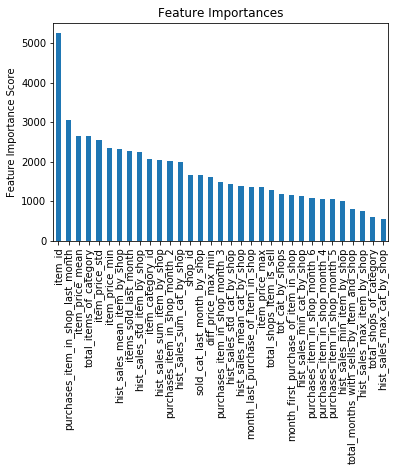

In [52]:
target_col = "label"

predictors = [x for x in F.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=optimal_parameters["max_depth"],
 min_child_weight=optimal_parameters["min_child_weight"],
 gamma=optimal_parameters["gamma"],
 subsample=optimal_parameters["subsample"],
 colsample_bytree=optimal_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost, F, predictors, target_col)

In [53]:
test_predictions = xgboost.predict(f[predictors])

In [54]:
root_mean_squared_error(f[target_col], test_predictions)

1.223359989656335

In [55]:
jb.dump(xgboost, "models/10-xgb_more_examples.pkl")

['models/10-xgb_more_examples.pkl']

In [164]:
predictors

['shop_id',
 'item_id',
 'item_category_id',
 'hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_item_in_shop_month_4',
 'purchases_item_in_shop_month_5',
 'purchases_item_in_shop_month_6',
 'month_last_purchase_of_item_in_shop',
 'month_first_purchase_of_item_in_shop',
 'total_months_with_sells_by_item_and_shop',
 'item_price_max',
 'item_price_mean',
 'item_price_min',
 'item_price_std',
 'diff_price_max_min',
 'total_shops_item_is_sell']

# RANDOM FOREST

### Analyze NA values

In [19]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                      0
hist_sales_mean_cat_by_shop                     0
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                      0
hist_sales_max_cat_by_shop                      0
sold_cat_last_month_by_shop                     0
total_shops_of_category                         2
total_items_of_category                         2
tot_cat_by_shops                                0
items_sold_last_month                           0
hist_sales_mean_item_by_shop                    0
hist_sales_sum_item_by_shop                     0
hist_sales_std_item_by_shop                 37875
hist_sales_max_item_by_shop                     0
hist_sales_min_item_by_shop                     0
purchases_item_in_shop_last_month               0


In [20]:
# For item_price features, take main of category
grouped = df.groupby("item_category_id").agg({"item_price_max":"mean", "item_price_mean":"mean", "item_price_min":"mean", "item_price_std":"mean", "diff_price_max_min":"mean"}).reset_index()
grouped.head()

,item_category_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min
0,2,3204.160142,2676.985301,1950.979253,275.245913,1253.180890
1,3,2879.226732,2277.276775,1576.107446,236.696546,1303.119286
2,4,399.000000,380.799624,98.000000,53.523906,301.000000
3,5,712.668966,620.084411,264.430069,70.666692,448.238897
4,6,3067.106299,2170.196344,1282.213130,346.751304,1784.893169


In [21]:
df["id"] = [x for x in range(len(df))]
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,tot_cat_by_shops,items_sold_last_month,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,id
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,59.0,822.0,1.750,7.0,1.500000,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,4.0,699.0,581.503264,147.62,152.605715,551.38,53.0,0
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,59.0,822.0,1.625,13.0,0.744024,3.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0,1
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,0.0,55.0,160.0,59.0,822.0,1.000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0,2
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,59.0,822.0,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3300.0,3282.352941,3000.00,72.760688,300.00,8.0,3
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,59.0,822.0,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,399.0,357.765780,55.00,90.061632,344.00,43.0,4


In [22]:
df_item_price_na = df[df.item_price_max.isna()]
df_item_price_na.drop(columns=["item_price_max", "item_price_mean", "item_price_std", "item_price_min", "diff_price_max_min"], inplace=True)
print(len(df_item_price_na))

7997


/home/urielkelman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
df_item_price_na = pd.merge(df_item_price_na, grouped, on="item_category_id", how="inner")
print(len(df_item_price_na))

df_item_price_na = df_item_price_na[df.columns]
print(len(df_item_price_na))
df_item_price_na.columns == df.columns

7997
7997


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [24]:
print(len(df))
df = df_item_price_na.append(df).drop_duplicates(subset=["id"], keep="first").drop(columns=["id"])
print(len(df))
df.head()

126961
126961


,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,tot_cat_by_shops,items_sold_last_month,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell
0,2,1578,4.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,59.0,822.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN
1,2,1583,9.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,59.0,822.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN
2,2,1586,1.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,59.0,822.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN
3,2,3034,1.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,59.0,822.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN
4,2,3756,2.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,59.0,822.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN


In [28]:
df["hist_sales_std_cat_by_shop"] = df["hist_sales_std_cat_by_shop"].fillna(0)
df["hist_sales_std_item_by_shop"] = df["hist_sales_std_item_by_shop"].fillna(0)
df["month_last_purchase_of_item_in_shop"] = df["month_last_purchase_of_item_in_shop"].fillna(-1)
df["month_first_purchase_of_item_in_shop"] = df["month_first_purchase_of_item_in_shop"].fillna(-1)
df["item_price_std"] = df["item_price_std"].fillna(0)
df["total_shops_item_is_sell"] = df["total_shops_item_is_sell"].fillna(0)
df["total_shops_of_category"] = df["total_shops_of_category"].fillna(0)
df["total_items_of_category"] = df["total_items_of_category"].fillna(0)

In [29]:
df.isna().sum()

shop_id                                     0
item_id                                     0
label                                       0
item_category_id                            0
hist_sales_sum_cat_by_shop                  0
hist_sales_mean_cat_by_shop                 0
hist_sales_std_cat_by_shop                  0
hist_sales_min_cat_by_shop                  0
hist_sales_max_cat_by_shop                  0
sold_cat_last_month_by_shop                 0
total_shops_of_category                     0
total_items_of_category                     0
tot_cat_by_shops                            0
items_sold_last_month                       0
hist_sales_mean_item_by_shop                0
hist_sales_sum_item_by_shop                 0
hist_sales_std_item_by_shop                 0
hist_sales_max_item_by_shop                 0
hist_sales_min_item_by_shop                 0
purchases_item_in_shop_last_month           0
purchases_item_in_shop_month_2              0
purchases_item_in_shop_month_3    

### Split, train and save model

In [40]:
features = df

target_col = "label"
predictors = [x for x in features.columns if x != target_col]
predictors

['shop_id',
 'item_id',
 'item_category_id',
 'hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_item_in_shop_month_4',
 'purchases_item_in_shop_month_5',
 'purchases_item_in_shop_month_6',
 'month_last_purchase_of_item_in_shop',
 'month_first_purchase_of_item_in_shop',
 'total_months_with_sells_by_item_and_shop',
 'item_price_max',
 'item_price_mean',
 'item_price_min',
 'item_price_std',
 'diff_price_max_min',
 'total_shops_item_is_sell']

In [41]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [42]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [43]:
regressor = RandomForestRegressor(n_jobs=4, random_state=27, criterion="mse")

In [46]:
clf = RandomizedSearchCV(regressor, random_grid, random_state=27, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)

In [48]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 154.9min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=4, oob_score=False,
                                                   random_s...


In [49]:
jb.dump(clf, "aux.pkl")

['aux.pkl']

In [50]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=4,
                      oob_score=False, random_state=27, verbose=0,
                      warm_start=False)

In [ ]:
w